In [6]:
# loading and inspecting dataset.

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/raw/titanic.csv")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
df.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Dataset Quality Summary**

# Missing values.

- **Age:** 177 missing (~19.9% of 891).
- **Cabin:** 687 missing (~77.1%).
- **Embarked:** 2 missing (~0.2%).
- All other columns reported as fully non-null.

# Column types.

- **Integers:** PassengerId, Survived, Pclass, SibSp, Parch.
- **Floats:** Age, Fare.
- **Objects (strings):** Name, Sex, Ticket, Cabin, Embarked.

# Irrelevant / questionable columns.

- **PassengerId:** identifier — usually dropped or set as index (no predictive value).
- **Name:** raw text / high-cardinality — not useful as-is; consider extracting `Title` (Mr/Mrs/etc.) if needed.
- **Ticket:** high-cardinality / noisy — often dropped unless parsing prefixes/groups.
- **Cabin:** very sparse — either drop, fill with `Unknown`, or extract deck letter (first character) for limited signal.



# How severe is the missingness?

- **Age (≈20%) — Moderate:** 177 / 891 missing. Enough to require careful imputation to avoid bias, but not so large that imputation is infeasible.
  
- **Cabin (≈77%) — Severe:** 687 / 891 missing. Extremely sparse — most rows lack cabin information, so relying on raw `Cabin` values is risky.
  
- **Embarked (≈0.2%) — Negligible:** 2 / 891 missing. Very small; simple imputation is appropriate.

# What cleaning strategy makes sense and why?

- **`Age` — Impute + flag:** Impute using median (robust) or a small predictive model (if you want better accuracy), and add an `age_missing` indicator column. Rationale: 20% missing can bias models if ignored; a missingness flag captures potential informative missingness.

- **`Cabin` — Reduce / transform or drop:** Options:
  - Extract deck letter (first character) where present and set missing to `Unknown` — keeps limited signal while avoiding sparse raw values.
  - Or drop `Cabin` entirely if downstream models do not benefit (given 77% missingness). Rationale: extremely high missingness means most information would be noise unless aggregated.

- **`Embarked` — Simple imputation:** Fill the 2 missing with the mode (most common port) or mark as `Missing` (small effect either way). Rationale: negligible missing rate — simple strategies suffice.

- **Identifiers / high-cardinality fields:**
  - Drop or index `PassengerId` (identifier only).
  - Drop `Ticket`, and drop or transform `Name` (extract `Title` if useful). Rationale: These fields are noisy or high-cardinality and often provide little direct predictive power without feature engineering.

- **General recommendation:** Create explicit missingness indicator columns for features with non-trivial missing rates (e.g., `age_missing`, `cabin_missing`) so models can learn any signal from missingness itself.




In [9]:
# Data cleaning.

cleaned = df.copy()

# Extract simple Title feature
cleaned['Title'] = cleaned['Name'].str.extract(r',\s*([^.]*)\.', expand=False).fillna('Unknown')
common_titles = ['Mr','Mrs','Miss','Master','Dr','Rev']
cleaned['Title'] = cleaned['Title'].apply(lambda t: t if t in common_titles else 'Other')

# Age: median imputation + missing flag
cleaned['age_missing'] = cleaned['Age'].isnull().astype(int)
cleaned['Age'] = cleaned['Age'].fillna(cleaned['Age'].median())

# Cabin: extract deck letter (or 'Unknown') and flag
cleaned['CabinDeck'] = cleaned['Cabin'].fillna('Unknown').astype(str).str[0]
cleaned['CabinDeck'] = cleaned['CabinDeck'].replace({'': 'Unknown'})
cleaned['cabin_missing'] = (cleaned['CabinDeck'] == 'Unknown').astype(int)

# Embarked: fill small number of missings with mode.

if cleaned['Embarked'].isnull().any():
    cleaned['Embarked'] = cleaned['Embarked'].fillna(cleaned['Embarked'].mode()[0])

# Drop identifier/noisy columns.

drop_cols = [c for c in ['PassengerId','Ticket','Name','Cabin'] if c in cleaned.columns]
if drop_cols:
    cleaned = cleaned.drop(columns=drop_cols)

# Cast common categoricals.

for c in ['Sex','Embarked','Title','CabinDeck']:
    if c in cleaned.columns:
        cleaned[c] = cleaned[c].astype('category')

# Save cleaned dataset.
out_path = '../data/cleaned/titanic_cleaned.csv'
cleaned.to_csv(out_path, index=False)
print('Saved cleaned dataset to', out_path)

# Quick check.
cleaned.head()


Saved cleaned dataset to ../data/cleaned/titanic_cleaned.csv


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,age_missing,CabinDeck,cabin_missing
0,0,3,male,22.0,1,0,7.2500,S,Mr,0,U,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs,0,C,0
2,1,3,female,26.0,0,0,7.9250,S,Miss,0,U,0
3,1,1,female,35.0,1,0,53.1000,S,Mrs,0,C,0
4,0,3,male,35.0,0,0,8.0500,S,Mr,0,U,0


In [10]:
df.groupby('Sex')['Survived'].mean()
df.groupby('Pclass')['Survived'].mean()


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [ ]:
**Survival Analysis: Sex, Class, and Age**

# Survival rate by sex.

- Compute: `df.groupby('Sex')['Survived'].mean()` — gives the survival proportion by sex.
- Typical finding: females tend to have a substantially higher survival rate than males; report percentages and counts with `df['Sex'].value_counts()`.
- Suggested plot: bar chart of survival rate by sex (show percentages and sample sizes).

Example code:

```python
sex_rates = df.groupby('Sex')['Survived'].mean()
sex_counts = df['Sex'].value_counts()
print(sex_rates)
```

# Survival rate by passenger class (Pclass).

- Compute: `df.groupby('Pclass')['Survived'].mean()` — compares classes 1, 2, 3.
- Typical finding: higher classes (1st) show higher survival than lower classes (3rd).
- Suggested plot: ordered bar chart or point plot showing survival rate per class with counts.

Example code:

```python
class_rates = df.groupby('Pclass')['Survived'].mean()
print(class_rates)
```

# Age distribution of survivors.

- Compare age distributions for survivors vs non-survivors to see whether survival varied by age.
- Useful visuals: overlapping KDEs, side-by-side boxplots, or violin plots.
- Also check whether missing ages are biased by survival: `df.groupby('Survived')['age_missing'].mean()`.

Example code:

```python
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(data=df, x='Age', hue='Survived', common_norm=False)
plt.title('Age distribution: Survivors vs Non-survivors')
plt.show()

sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Age by Survival')
plt.show()
```

# Quick interpretation checklist.

- Report exact percentages for sex and class survival rates and comment on effect sizes.
- Examine whether younger passengers survived more often (visual + summary stats).
- Check whether age imputation or missingness could bias conclusions; include `age_missing` comparisons.

Run the example code cells above to generate the numbers and plots; tell me if you want me to insert those code cells for you.

Survival rate by Sex:
            rate  count
Sex                    
female  0.742038    314
male    0.188908    577


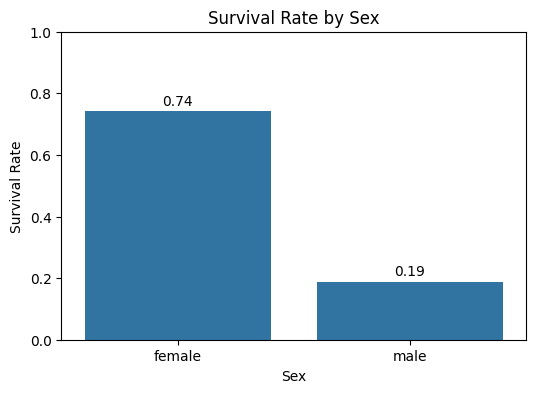


Survival rate by Pclass:
            rate  count
Pclass                 
1       0.629630    216
2       0.472826    184
3       0.242363    491


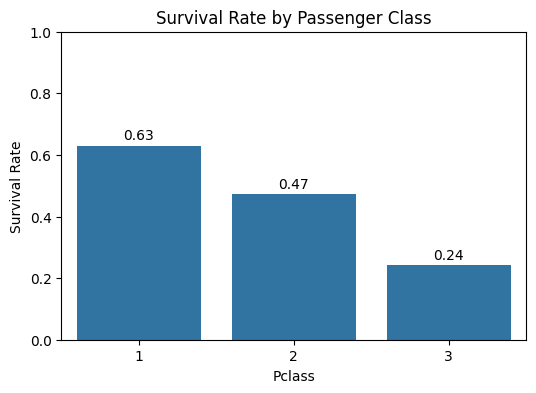

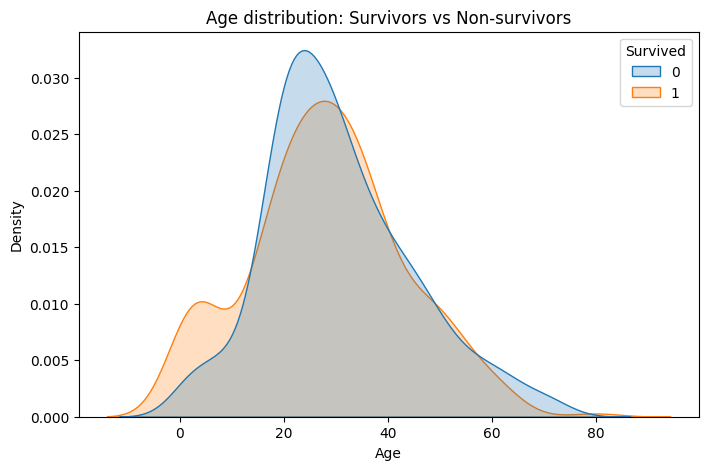

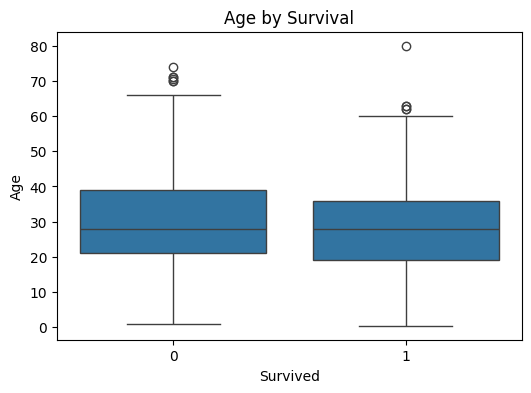


No age_missing flag present; consider adding one before imputation if needed.


In [11]:
# Compute and plot survival summaries.
import seaborn as sns
import matplotlib.pyplot as plt

# Survival rate by sex.
sex_rates = df.groupby('Sex')['Survived'].mean()
sex_counts = df['Sex'].value_counts()
print("Survival rate by Sex:")
print(pd.DataFrame({'rate': sex_rates, 'count': sex_counts}))
plt.figure(figsize=(6,4))
sns.barplot(x=sex_rates.index, y=sex_rates.values)
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Sex')
for i, v in enumerate(sex_rates.values):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
plt.ylim(0,1)
plt.show()

# Survival rate by Pclass.
class_rates = df.groupby('Pclass')['Survived'].mean().sort_index()
class_counts = df['Pclass'].value_counts().sort_index()
print("\nSurvival rate by Pclass:")
print(pd.DataFrame({'rate': class_rates, 'count': class_counts}))
plt.figure(figsize=(6,4))
sns.barplot(x=class_rates.index.astype(str), y=class_rates.values)
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Passenger Class')
for i, v in enumerate(class_rates.values):
    plt.text(i, v+0.02, f"{v:.2f}", ha='center')
plt.ylim(0,1)
plt.show()

# Age distribution of survivors vs non-survivors.
plt.figure(figsize=(8,5))
# drop NA ages for plotting
age_df = df.dropna(subset=['Age'])
sns.kdeplot(data=age_df, x='Age', hue='Survived', common_norm=False, fill=True)
plt.title('Age distribution: Survivors vs Non-survivors')
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='Survived', y='Age', data=age_df)
plt.title('Age by Survival')
plt.show()

# Check whether age missingness correlates with survival.
if 'age_missing' in df.columns:
    print('\nProportion age missing by survival:')
    print(df.groupby('Survived')['age_missing'].mean())
else:
    print('\nNo age_missing flag present; consider adding one before imputation if needed.')
